In [1]:
# import packages
import pandas as pd
import os
import sys
import mysql.connector
import numpy as np
import datetime
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor

import joblib
from joblib import load, dump
import pickle
import json

# Import Data and Investigate

In [2]:
# load trip data as csv
df_trips = pd.read_csv('/Users/danhowes1/Desktop/UCD/Research_Project/rt_trips_DB_2018.csv')

In [3]:
# Check how many rows and columns this dataframe has
df_trips.shape

(2182637, 16)

In [4]:
# check first 10 rows
df_trips.head(10)

,DATASOURCE,DAYOFSERVICE,TRIPID,LINEID,ROUTEID,DIRECTION,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,BASIN,TENDERLOT,SUPPRESSED,JUSTIFICATIONID,LASTUPDATE,NOTE
0,DB,07-FEB-18 00:00:00,6253783,68,68_80,1,87245,84600,87524.0,84600.0,BasDef,NaN,NaN,NaN,28-FEB-18 12:05:11,",2967409,"
1,DB,07-FEB-18 00:00:00,6262138,25B,25B_271,2,30517,26460,32752.0,NaN,BasDef,NaN,NaN,NaN,28-FEB-18 12:05:11,",2580260,"
2,DB,07-FEB-18 00:00:00,6254942,45A,45A_70,2,35512,32100,36329.0,32082.0,BasDef,NaN,NaN,NaN,28-FEB-18 12:05:11,",2448968,"
3,DB,07-FEB-18 00:00:00,6259460,25A,25A_273,1,57261,54420,58463.0,54443.0,BasDef,NaN,NaN,NaN,28-FEB-18 12:05:11,",3094242,"
4,DB,07-FEB-18 00:00:00,6253175,14,14_15,1,85383,81600,84682.0,81608.0,BasDef,NaN,NaN,NaN,28-FEB-18 12:05:11,",2526331,"
5,DB,07-FEB-18 00:00:00,6248240,77A,77A_28,2,41648,37200,42019.0,37538.0,BasDef,NaN,NaN,NaN,28-FEB-18 12:05:11,",2966500,"
6,DB,07-FEB-18 00:00:00,6251760,39,39_21,2,34768,28920,35709.0,28929.0,BasDef,NaN,NaN,NaN,28-FEB-18 12:05:11,",2422850,"
7,DB,07-FEB-18 00:00:00,6262909,16,16_20,1,43936,38880,43721.0,38955.0,BasDef,NaN,NaN,NaN,28-FEB-18 12:05:11,",3045261,"
8,DB,07-FEB-18 00:00:00,6251147,40D,40D_102,1,33558,30600,34540.0,31185.0,BasDef,NaN,NaN,NaN,28-FEB-18 12:05:11,",2837123,"
9,DB,07-FEB-18 00:00:00,6249435,27B,27B_34,2,52682,49800,53281.0,49974.0,BasDef,NaN,NaN,NaN,28-FEB-18 12:05:11,",2329338,"


In [5]:
#Now check type of each feature
df_trips.dtypes

DATASOURCE          object
DAYOFSERVICE        object
TRIPID               int64
LINEID              object
ROUTEID             object
DIRECTION            int64
PLANNEDTIME_ARR      int64
PLANNEDTIME_DEP      int64
ACTUALTIME_ARR     float64
ACTUALTIME_DEP     float64
BASIN               object
TENDERLOT          float64
SUPPRESSED         float64
JUSTIFICATIONID    float64
LASTUPDATE          object
NOTE                object
dtype: object

<b> - Look for duplicate rows and columns. Consider whether it makes sense to keep them or drop them. </b>

In [6]:
#Print the number of duplicates, without the original rows that were duplicated
print('Number of duplicate (excluding first) rows in the table is: ', df_trips.duplicated().sum())

# Check for duplicate rows. 
# Use "keep=False" to mark all duplicates as true, including the original rows that were duplicated.
print('Number of duplicate rows (including first) in the table is:', df_trips[df_trips.duplicated(keep=False)].shape[0])


Number of duplicate (excluding first) rows in the table is:  0
Number of duplicate rows (including first) in the table is: 0


In [7]:
#check number of empty rows per feature
df_trips.isnull().sum()

DATASOURCE               0
DAYOFSERVICE             0
TRIPID                   0
LINEID                   0
ROUTEID                  0
DIRECTION                0
PLANNEDTIME_ARR          0
PLANNEDTIME_DEP          0
ACTUALTIME_ARR      137207
ACTUALTIME_DEP      164551
BASIN                    0
TENDERLOT          2182637
SUPPRESSED         2178304
JUSTIFICATIONID    2178307
LASTUPDATE               0
NOTE                     0
dtype: int64

In [8]:
#check cardinality of each feature
df_trips.nunique()

DATASOURCE              1
DAYOFSERVICE          360
TRIPID             658964
LINEID                130
ROUTEID               588
DIRECTION               2
PLANNEDTIME_ARR     64461
PLANNEDTIME_DEP       791
ACTUALTIME_ARR      68122
ACTUALTIME_DEP      66771
BASIN                   1
TENDERLOT               0
SUPPRESSED              1
JUSTIFICATIONID      3526
LASTUPDATE            360
NOTE                46690
dtype: int64

# Cleaning Dataset

<b> - Drop constant and null columns </b>

- LASTUPDATE is irrelevant so we can drop that feature

In [9]:
# drop columns with a cardinality of 1
constant_columns = ['DATASOURCE', 'BASIN', 'TENDERLOT', 'SUPPRESSED', 'JUSTIFICATIONID', 'LASTUPDATE']

for c in constant_columns:
    df_trips = df_trips.drop(c, 1)

df_trips.head(10)

/var/folders/bn/6x11zktd6n14vfwyb0jymgt00000gp/T/ipykernel_58238/4267794298.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_trips = df_trips.drop(c, 1)


,DAYOFSERVICE,TRIPID,LINEID,ROUTEID,DIRECTION,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,NOTE
0,07-FEB-18 00:00:00,6253783,68,68_80,1,87245,84600,87524.0,84600.0,",2967409,"
1,07-FEB-18 00:00:00,6262138,25B,25B_271,2,30517,26460,32752.0,NaN,",2580260,"
2,07-FEB-18 00:00:00,6254942,45A,45A_70,2,35512,32100,36329.0,32082.0,",2448968,"
3,07-FEB-18 00:00:00,6259460,25A,25A_273,1,57261,54420,58463.0,54443.0,",3094242,"
4,07-FEB-18 00:00:00,6253175,14,14_15,1,85383,81600,84682.0,81608.0,",2526331,"
5,07-FEB-18 00:00:00,6248240,77A,77A_28,2,41648,37200,42019.0,37538.0,",2966500,"
6,07-FEB-18 00:00:00,6251760,39,39_21,2,34768,28920,35709.0,28929.0,",2422850,"
7,07-FEB-18 00:00:00,6262909,16,16_20,1,43936,38880,43721.0,38955.0,",3045261,"
8,07-FEB-18 00:00:00,6251147,40D,40D_102,1,33558,30600,34540.0,31185.0,",2837123,"
9,07-FEB-18 00:00:00,6249435,27B,27B_34,2,52682,49800,53281.0,49974.0,",2329338,"


In [10]:
# check number of empty values
df_trips.isnull().sum()

DAYOFSERVICE            0
TRIPID                  0
LINEID                  0
ROUTEID                 0
DIRECTION               0
PLANNEDTIME_ARR         0
PLANNEDTIME_DEP         0
ACTUALTIME_ARR     137207
ACTUALTIME_DEP     164551
NOTE                    0
dtype: int64

<b> - Planned arrival times vs actual arrival times for each stop </b>

- check if planned times are different to actual times

In [11]:
df_trips[df_trips['PLANNEDTIME_ARR'] == df_trips['ACTUALTIME_ARR']]

,DAYOFSERVICE,TRIPID,LINEID,ROUTEID,DIRECTION,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,NOTE
438,26-SEP-18 00:00:00,7773484,76,76_36,1,72413,70200,72413.0,70213.0,",1861541,"
1856,18-FEB-18 00:00:00,6267124,33,33_44,1,56669,51300,56669.0,51299.0,",2872281,"
2107,11-APR-18 00:00:00,6628614,145,145_105,2,81697,78000,81697.0,78025.0,",2421170,"
2811,18-FEB-18 00:00:00,6264692,15B,15B_61,2,32113,29700,32113.0,29641.0,",2986753,"
3884,18-FEB-18 00:00:00,6271794,13,13_60,1,55786,50400,55786.0,50296.0,",1745001,"
...,...,...,...,...,...,...,...,...,...,...
2171491,08-JAN-18 00:00:00,6096605,66,66_13,2,81147,78300,81147.0,78369.0,",2293879,"
2176791,16-MAY-18 00:00:00,6756982,63,63_26,1,34264,31500,34264.0,31533.0,",2796976,"
2177881,15-MAY-18 00:00:00,6766835,15A,15A_83,1,62361,59400,62361.0,59412.0,",3246556,"
2180597,15-MAY-18 00:00:00,6751451,102,102_9,2,58340,54600,58340.0,54601.0,",1732379,"


Clearly both columns contain different information and we'll keep both

<b> - Planned departure times vs Actual departure times for each stop </b>

In [12]:
df_trips[df_trips['PLANNEDTIME_DEP'] == df_trips['ACTUALTIME_DEP']]

,DAYOFSERVICE,TRIPID,LINEID,ROUTEID,DIRECTION,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,NOTE
0,07-FEB-18 00:00:00,6253783,68,68_80,1,87245,84600,87524.0,84600.0,",2967409,"
29,07-FEB-18 00:00:00,6245836,9,9_5,1,64573,59400,64689.0,59400.0,",3104100,"
61,18-FEB-18 00:00:00,6271543,65B,65B_66,2,62779,59400,64570.0,59400.0,",2818492,"
86,18-FEB-18 00:00:00,6268938,38A,38A_32,2,77332,74700,78551.0,74700.0,",2427894,"
204,11-MAR-18 00:00:00,6392156,46A,46A_74,1,80158,77400,80661.0,77400.0,",2453506,"
...,...,...,...,...,...,...,...,...,...,...
2182074,15-MAY-18 00:00:00,6756761,4,4_10,1,76936,72900,76572.0,72900.0,",2612192,"
2182283,15-MAY-18 00:00:00,6763274,46A,46A_74,1,39339,35040,39593.0,35040.0,",3061067,"
2182379,15-MAY-18 00:00:00,6751173,15,15_16,1,72892,67800,72566.0,67800.0,",3248201,"
2182398,15-MAY-18 00:00:00,6766826,15A,15A_84,2,30008,26400,30211.0,26400.0,",3246519,"


These two columns are different so we'll keep both

<b> - Extract data from DAYOFSERVICE  </b>

In [13]:
df_trips.head(10)

,DAYOFSERVICE,TRIPID,LINEID,ROUTEID,DIRECTION,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,NOTE
0,07-FEB-18 00:00:00,6253783,68,68_80,1,87245,84600,87524.0,84600.0,",2967409,"
1,07-FEB-18 00:00:00,6262138,25B,25B_271,2,30517,26460,32752.0,NaN,",2580260,"
2,07-FEB-18 00:00:00,6254942,45A,45A_70,2,35512,32100,36329.0,32082.0,",2448968,"
3,07-FEB-18 00:00:00,6259460,25A,25A_273,1,57261,54420,58463.0,54443.0,",3094242,"
4,07-FEB-18 00:00:00,6253175,14,14_15,1,85383,81600,84682.0,81608.0,",2526331,"
5,07-FEB-18 00:00:00,6248240,77A,77A_28,2,41648,37200,42019.0,37538.0,",2966500,"
6,07-FEB-18 00:00:00,6251760,39,39_21,2,34768,28920,35709.0,28929.0,",2422850,"
7,07-FEB-18 00:00:00,6262909,16,16_20,1,43936,38880,43721.0,38955.0,",3045261,"
8,07-FEB-18 00:00:00,6251147,40D,40D_102,1,33558,30600,34540.0,31185.0,",2837123,"
9,07-FEB-18 00:00:00,6249435,27B,27B_34,2,52682,49800,53281.0,49974.0,",2329338,"


<b> - Create 3 new columns to discretise temporal data</b>

In [14]:
# create 3 new columns that classify the hour, weekday and month of each service
df_trips['HOUROFSERVICE'] = np.nan
df_trips['WEEKDAYOFSERVICE'] = np.nan
df_trips['MONTHOFSERVICE'] = np.nan

df_trips['HOUROFSERVICE'] = df_trips['HOUROFSERVICE'].astype('object')


In [15]:
# extract hour of service and reformat DAYOFSERVICE
months = {'JAN': '01', 'FEB': '02', 'MAR': '03', 'APR': '04', 'MAY': '05', 'JUN': '06', 'JUL': '07', 'AUG': '08', 'SEP': '09', 'OCT': '10', 'NOV': '11', 'DEC': '12'}

for i in range(0, len(df_trips)):
    date = df_trips['DAYOFSERVICE'][i].split()
    datesplit = date[0].split("-")
    if datesplit[2] == '18':
        year = '2018'
    else:
        year = 'wrongyear'
        
    day = year+'-'+months[datesplit[1]]+'-'+datesplit[0]+' '+date[1]
    dated = datetime.datetime.strptime(day, "%Y-%m-%d %H:%M:%S")
    
    df_trips.at[i, 'WEEKDAYOFSERVICE'] = dated.weekday()
    df_trips.at[i, 'MONTHOFSERVICE'] = dated.month
    
    df_trips.at[i, 'HOUROFSERVICE'] = date[1]


In [16]:
# check cardinality of new features
df_trips.nunique()

DAYOFSERVICE           360
TRIPID              658964
LINEID                 130
ROUTEID                588
DIRECTION                2
PLANNEDTIME_ARR      64461
PLANNEDTIME_DEP        791
ACTUALTIME_ARR       68122
ACTUALTIME_DEP       66771
NOTE                 46690
HOUROFSERVICE            1
WEEKDAYOFSERVICE         7
MONTHOFSERVICE          12
dtype: int64

In [17]:
df_trips.isnull().sum()

DAYOFSERVICE             0
TRIPID                   0
LINEID                   0
ROUTEID                  0
DIRECTION                0
PLANNEDTIME_ARR          0
PLANNEDTIME_DEP          0
ACTUALTIME_ARR      137207
ACTUALTIME_DEP      164551
NOTE                     0
HOUROFSERVICE            0
WEEKDAYOFSERVICE         0
MONTHOFSERVICE           0
dtype: int64

- HOUROFSERVICE is a constant column so we can drop it

In [18]:
df_trips = df_trips.drop('HOUROFSERVICE', 1)

/var/folders/bn/6x11zktd6n14vfwyb0jymgt00000gp/T/ipykernel_58238/91954943.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_trips = df_trips.drop('HOUROFSERVICE', 1)


In [19]:
df_trips[df_trips['ACTUALTIME_DEP'].isnull()].nunique()

DAYOFSERVICE           360
TRIPID              103701
LINEID                 129
ROUTEID                560
DIRECTION                2
PLANNEDTIME_ARR      46046
PLANNEDTIME_DEP        757
ACTUALTIME_ARR       57198
ACTUALTIME_DEP           0
NOTE                 20722
WEEKDAYOFSERVICE         7
MONTHOFSERVICE          12
dtype: int64

- There are still empty values for actual arrival and actual departure times which we will drop

In [20]:
df_trips = df_trips[df_trips['ACTUALTIME_ARR'].notnull() & df_trips['ACTUALTIME_DEP'].notnull()]
df_trips.shape

(1893367, 12)

In [21]:
# reindex rows
df_trips.reset_index(drop=True, inplace=True)

<b> - Logic check </b>

In [22]:
df_trips.head(10)

,DAYOFSERVICE,TRIPID,LINEID,ROUTEID,DIRECTION,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,NOTE,WEEKDAYOFSERVICE,MONTHOFSERVICE
0,07-FEB-18 00:00:00,6253783,68,68_80,1,87245,84600,87524.0,84600.0,",2967409,",2.0,2.0
1,07-FEB-18 00:00:00,6254942,45A,45A_70,2,35512,32100,36329.0,32082.0,",2448968,",2.0,2.0
2,07-FEB-18 00:00:00,6259460,25A,25A_273,1,57261,54420,58463.0,54443.0,",3094242,",2.0,2.0
3,07-FEB-18 00:00:00,6253175,14,14_15,1,85383,81600,84682.0,81608.0,",2526331,",2.0,2.0
4,07-FEB-18 00:00:00,6248240,77A,77A_28,2,41648,37200,42019.0,37538.0,",2966500,",2.0,2.0
5,07-FEB-18 00:00:00,6251760,39,39_21,2,34768,28920,35709.0,28929.0,",2422850,",2.0,2.0
6,07-FEB-18 00:00:00,6262909,16,16_20,1,43936,38880,43721.0,38955.0,",3045261,",2.0,2.0
7,07-FEB-18 00:00:00,6251147,40D,40D_102,1,33558,30600,34540.0,31185.0,",2837123,",2.0,2.0
8,07-FEB-18 00:00:00,6249435,27B,27B_34,2,52682,49800,53281.0,49974.0,",2329338,",2.0,2.0
9,07-FEB-18 00:00:00,6251483,142,142_9,2,44024,43200,44145.0,43187.0,",2343693,",2.0,2.0


In [23]:
df_trips.isnull().sum()

DAYOFSERVICE        0
TRIPID              0
LINEID              0
ROUTEID             0
DIRECTION           0
PLANNEDTIME_ARR     0
PLANNEDTIME_DEP     0
ACTUALTIME_ARR      0
ACTUALTIME_DEP      0
NOTE                0
WEEKDAYOFSERVICE    0
MONTHOFSERVICE      0
dtype: int64

- check dates are valid

In [26]:
years = []
months = []
days = []

for i in range(0, len(df_trips)):
    day = df_trips['DAYOFSERVICE'][i]
    date = datetime.datetime.strptime(day, "%Y-%m-%d")
    
    if (date.year not in years):
        years += [date.year]
    if (date.month not in months):
        months += [date.month]
    if (date.day not in days):
        days += [date.day]
        
print(years, months, days)
    

ValueError: time data '07-FEB-18 00:00:00' does not match format '%Y-%m-%d'

- Save dataset as new csv

In [24]:
# save cleaned data as new csv
# df_trips.to_csv ('/Users/danhowes1/Desktop/UCD/Research_Project/rt_trips_DB_2018_CLEANED.csv', index=None)

# Investigate Cleaned Data

In [3]:
# load cleaned csv
df = pd.read_csv('/Users/danhowes1/Desktop/UCD/Research_Project/rt_trips_DB_2018_CLEANED.csv')

In [4]:
df.head(5)

,DAYOFSERVICE,TRIPID,LINEID,ROUTEID,DIRECTION,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,NOTE,WEEKDAYOFSERVICE,MONTHOFSERVICE
0,07-FEB-18 00:00:00,6253783,68,68_80,1,87245,84600,87524.0,84600.0,",2967409,",2.0,2.0
1,07-FEB-18 00:00:00,6254942,45A,45A_70,2,35512,32100,36329.0,32082.0,",2448968,",2.0,2.0
2,07-FEB-18 00:00:00,6259460,25A,25A_273,1,57261,54420,58463.0,54443.0,",3094242,",2.0,2.0
3,07-FEB-18 00:00:00,6253175,14,14_15,1,85383,81600,84682.0,81608.0,",2526331,",2.0,2.0
4,07-FEB-18 00:00:00,6248240,77A,77A_28,2,41648,37200,42019.0,37538.0,",2966500,",2.0,2.0


In [5]:
df.dtypes

DAYOFSERVICE         object
TRIPID                int64
LINEID               object
ROUTEID              object
DIRECTION             int64
PLANNEDTIME_ARR       int64
PLANNEDTIME_DEP       int64
ACTUALTIME_ARR      float64
ACTUALTIME_DEP      float64
NOTE                 object
WEEKDAYOFSERVICE    float64
MONTHOFSERVICE      float64
dtype: object

In [6]:
# change the type of features
df['LINEID'] = df['LINEID'].astype('category')
df['WEEKDAYOFSERVICE'] = df['WEEKDAYOFSERVICE'].astype('category')
df['MONTHOFSERVICE'] = df['MONTHOFSERVICE'].astype('category')
df.dtypes

DAYOFSERVICE          object
TRIPID                 int64
LINEID              category
ROUTEID               object
DIRECTION              int64
PLANNEDTIME_ARR        int64
PLANNEDTIME_DEP        int64
ACTUALTIME_ARR       float64
ACTUALTIME_DEP       float64
NOTE                  object
WEEKDAYOFSERVICE    category
MONTHOFSERVICE      category
dtype: object

<b> - Plot histogram of the number of trips that took place on each weekday during the year </b>

<AxesSubplot:title={'center':'WEEKDAYOFSERVICE'}>

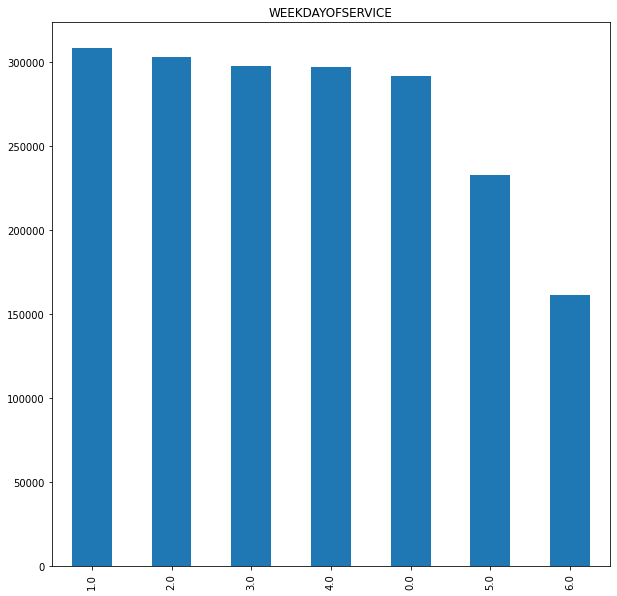

In [20]:
# show number of trips for each weekday
df['WEEKDAYOFSERVICE'].value_counts(dropna=False).plot(kind='bar', title='WEEKDAYOFSERVICE', figsize=(10,10))

<b> - Plot histogram of the number of trips that took place for each month during the year </b>

<AxesSubplot:title={'center':'MONTHOFSERVICE'}>

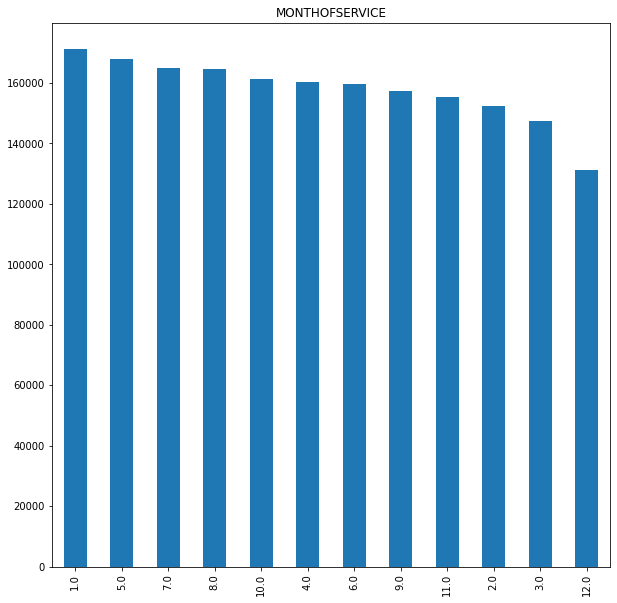

In [21]:
# show number of trips for each month
df['MONTHOFSERVICE'].value_counts(dropna=False).plot(kind='bar', title='MONTHOFSERVICE', figsize=(10,10))

<b> - Plot histogram of the number of trips that took place for each route/line during the year </b>

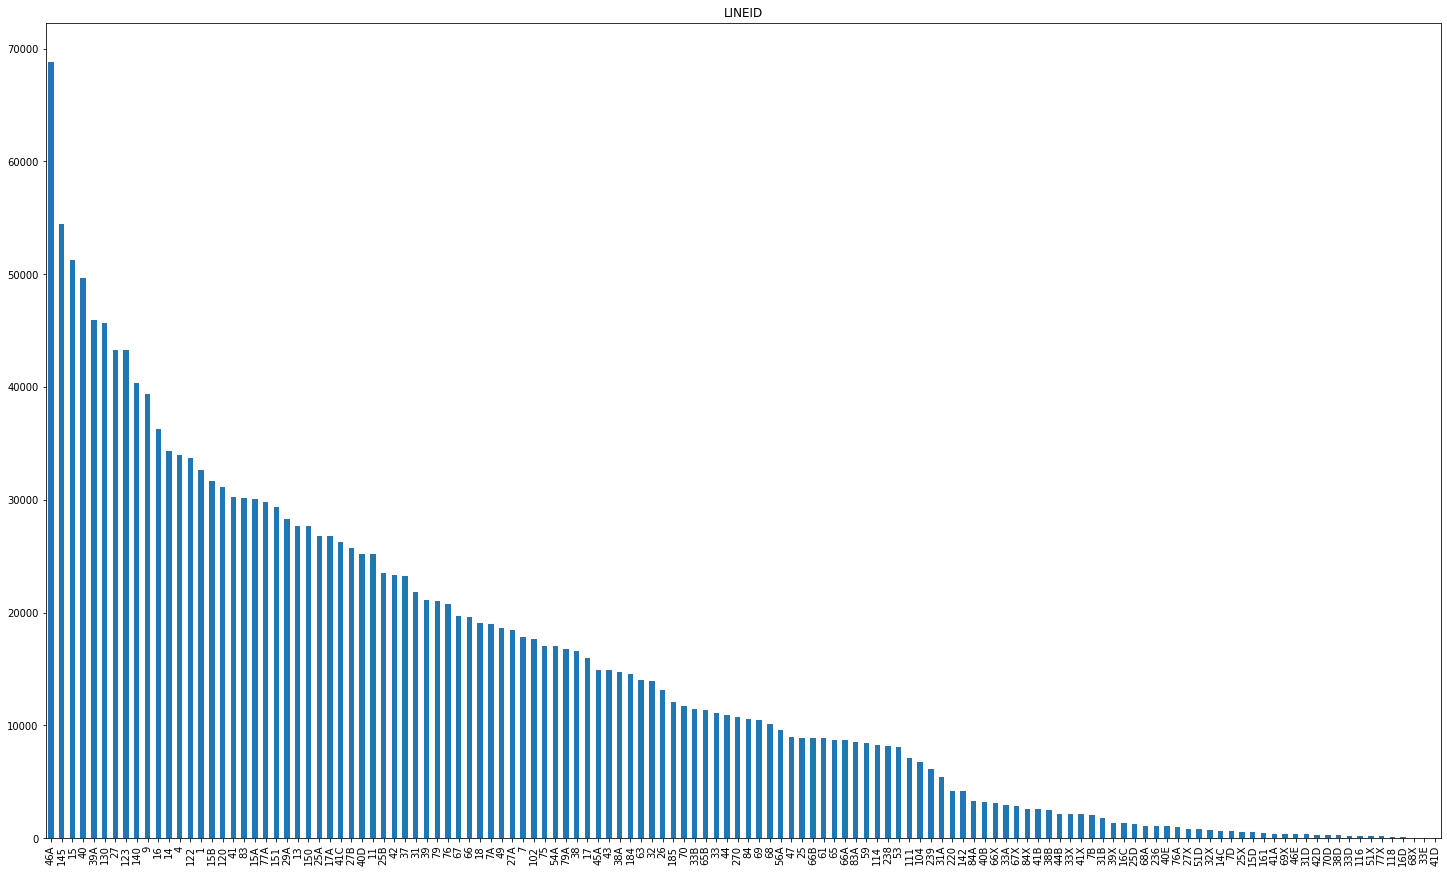

In [19]:
# show number of trips for each route/line
df['LINEID'].value_counts(dropna=False).plot(kind='bar', title='LINEID', figsize=(25,15))
plt.show()